In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.api as sm
from shapely.wkt import loads
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

import scipy.stats as stats
import networkx as nx  # for network analysis
import pycombo  # for community detection 
import geopandas as gpd
import shapely

In [2]:
#import tract level demographic data. We are most interested in total resident population and total jobs
tract_demo = pd.read_csv('../Data/demog_tract_level.csv')
tract_demo.head()

,Tract,Pop_Tot,Pop_18,%White,%Black,%Hispanic_Latino,%Asian,%Other,%Mixed,%Edu_hs,...,J_B_2,J_B_3,Median_Inc,Agg_Inc,M_Age_Wor,M_Age_All,Perc_Car,Perc_Trans,Perc_Bus,Perc_Subw
0,36005020000,4711,3310,2.759499,9.382297,61.197198,23.392061,2.080238,1.188707,71.873112,...,175,334,40184,78328200.0,42.0,32.7,17.677553,69.362364,11.145671,58.216693
1,36005020501,6976,5313,1.046445,26.333142,71.530963,0.788417,0.000000,0.301032,71.052136,...,225,146,17601,101308000.0,37.1,34.3,16.759537,65.452207,27.346764,38.105444
2,36005020502,2160,1737,1.666667,26.435185,71.481481,0.138889,0.000000,0.277778,64.824410,...,23,110,18919,40917200.0,33.6,39.3,24.831461,62.359551,26.292135,33.820225
3,36005020900,4287,3297,3.825519,37.602053,57.872638,0.256590,0.209937,0.233263,74.309979,...,79,209,31190,64260200.0,41.0,36.4,19.557416,70.454545,13.098086,57.356459
4,36005021001,8930,7185,2.183651,50.470325,36.125420,8.801792,1.209406,1.209406,85.901183,...,320,491,54076,252806100.0,40.3,39.0,22.057169,68.849876,15.890164,51.496736


In [3]:
tract_demo.columns

Index(['Tract', 'Pop_Tot', 'Pop_18', '%White', '%Black', '%Hispanic_Latino',
       '%Asian', '%Other', '%Mixed', '%Edu_hs', '%Edu_bac', 'J_Tot', 'J_W_1',
       'J_B_1', 'J_W_2', 'J_B_2', 'J_B_3', 'Median_Inc', 'Agg_Inc',
       'M_Age_Wor', 'M_Age_All', 'Perc_Car', 'Perc_Trans', 'Perc_Bus',
       'Perc_Subw'],
      dtype='object')

In [4]:
O_pop = tract_demo[['Tract','Pop_Tot','Pop_18']]
O_pop = O_pop.rename(columns = {'Tract':'O_Tract','Pop_Tot':'O_PopTot','Pop_18':'O_Pop18'})
O_pop.head()

,O_Tract,O_PopTot,O_Pop18
0,36005020000,4711,3310
1,36005020501,6976,5313
2,36005020502,2160,1737
3,36005020900,4287,3297
4,36005021001,8930,7185


In [5]:
#import CBD NTA geographies and aggregate tract demos to find destination populations

NTA_CBD = pd.read_csv('../Data/NTA_CBD_final.csv',index_col = 0)
NTA_CBD.head()

,ntacode,c000,area_km2,%_cbd_jobs,borocode,boroname,countyfips,ntaname,shape_area,shape_leng,geometry,Center_Lat,Center_Lon,jobs_km2
0,BK09,13119.0,0.161585,0.005953,3.0,Brooklyn,47,Brooklyn Heights-Cobble Hill,9.984670e+06,14253.675375,"POLYGON ((-73.99236367043254 40.689690123777, ...",40.695469,-73.994871,81189.237281
1,BK38,90452.0,0.336149,0.041043,3.0,Brooklyn,47,DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill,2.846257e+07,32363.990305,POLYGON ((-73.97905767012286 40.70595288910062...,40.692921,-73.985990,269083.057942
2,BK68,9567.0,0.164809,0.004341,3.0,Brooklyn,47,Fort Greene,1.648290e+07,19828.474410,POLYGON ((-73.96939450111498 40.69608038942066...,40.690795,-73.974881,58048.886737
3,BK73,9870.0,0.194892,0.004479,3.0,Brooklyn,47,North Side-South Side,2.886841e+07,28145.428770,POLYGON ((-73.95814292441031 40.72440428440242...,40.714916,-73.958625,50643.372409
4,BX43,15124.0,0.248715,0.006863,2.0,Bronx,5,Norwood,1.570888e+07,22148.645113,"POLYGON ((-73.8830938237215 40.86660218502373,...",40.877138,-73.879022,60808.524894


In [6]:
len(NTA_CBD)

22

In [7]:
NTA_CBD['geometry'] = NTA_CBD['geometry'].apply(loads) 
NTA_CBD = gpd.GeoDataFrame(NTA_CBD,geometry = 'geometry',crs = '4326')
print(type(NTA_CBD))

<class 'geopandas.geodataframe.GeoDataFrame'>


In [8]:
nta_cbd_dict = {'BK09': 'CBD1', 'BK38': 'CBD2', 'BK68': 'CBD3', 'BK73': 'CBD4',
                'BX43': 'CBD5', 'MN09': 'CBD6', 'MN13': 'CBD7', 'MN14': 'CBD8',
                'MN15': 'CBD9', 'MN17': 'CBD10', 'MN19': 'CBD11', 'MN20': 'CBD12',
                'MN21': 'CBD13', 'MN22': 'CBD14', 'MN23': 'CBD15', 'MN24': 'CBD16',
                'MN25': 'CBD17', 'MN27': 'CBD18', 'MN31': 'CBD19', 'MN33': 'CBD20',
                'MN40': 'CBD21', 'QN22': 'CBD22'}

NTA_CBD['CBD'] = NTA_CBD['ntacode'].map(nta_cbd_dict)
NTA_CBD.head()

,ntacode,c000,area_km2,%_cbd_jobs,borocode,boroname,countyfips,ntaname,shape_area,shape_leng,geometry,Center_Lat,Center_Lon,jobs_km2,CBD
0,BK09,13119.0,0.161585,0.005953,3.0,Brooklyn,47,Brooklyn Heights-Cobble Hill,9.984670e+06,14253.675375,"POLYGON ((-73.99236 40.68969, -73.99436 40.690...",40.695469,-73.994871,81189.237281,CBD1
1,BK38,90452.0,0.336149,0.041043,3.0,Brooklyn,47,DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill,2.846257e+07,32363.990305,"POLYGON ((-73.97906 40.70595, -73.97906 40.705...",40.692921,-73.985990,269083.057942,CBD2
2,BK68,9567.0,0.164809,0.004341,3.0,Brooklyn,47,Fort Greene,1.648290e+07,19828.474410,"POLYGON ((-73.96939 40.69608, -73.96938 40.695...",40.690795,-73.974881,58048.886737,CBD3
3,BK73,9870.0,0.194892,0.004479,3.0,Brooklyn,47,North Side-South Side,2.886841e+07,28145.428770,"POLYGON ((-73.95814 40.72440, -73.95772 40.724...",40.714916,-73.958625,50643.372409,CBD4
4,BX43,15124.0,0.248715,0.006863,2.0,Bronx,5,Norwood,1.570888e+07,22148.645113,"POLYGON ((-73.88309 40.86660, -73.88363 40.867...",40.877138,-73.879022,60808.524894,CBD5


In [39]:
type(NTA_CBD)

geopandas.geodataframe.GeoDataFrame

In [9]:
#join NTA_CBD and tracts
tracts_gdf = gpd.read_file('../Data/2010_Census_Tracts/2010_Census_Tracts.shp')
tracts_gdf.head()

,ctlabel,boro_code,boro_name,ct2010,boro_ct201,cdeligibil,ntacode,ntaname,puma,shape_leng,shape_area,geoid,Center_Lat,Center_Lon,area_km2,geometry
0,98,1,Manhattan,009800,1009800,I,MN19,Turtle Bay-East Midtown,3808,5534.20030845,1906016.47074,36061009800,40.755788,-73.967775,0.177075,"POLYGON ((-73.96433 40.75638, -73.96479 40.755..."
1,102,1,Manhattan,010200,1010200,I,MN17,Midtown-Midtown South,3807,5687.80243891,1860992.68163,36061010200,40.759424,-73.974449,0.172893,"POLYGON ((-73.97124 40.76094, -73.97170 40.760..."
2,104,1,Manhattan,010400,1010400,I,MN17,Midtown-Midtown South,3807,5693.03636707,1864600.43538,36061010400,40.760779,-73.977673,0.173228,"POLYGON ((-73.97446 40.76229, -73.97491 40.761..."
3,113,1,Manhattan,011300,1011300,I,MN17,Midtown-Midtown South,3807,5699.86064037,1890907.25105,36061011300,40.754775,-73.987870,0.175672,"POLYGON ((-73.98412 40.75484, -73.98460 40.754..."
4,130,1,Manhattan,013000,1013000,I,MN40,Upper East Side-Carnegie Hill,3805,5807.97295649,1918144.56374,36061013000,40.772736,-73.964734,0.178202,"POLYGON ((-73.96148 40.77432, -73.96194 40.773..."


In [10]:
nta_tracts = tracts_gdf[tracts_gdf['ntacode'].isin(NTA_CBD.ntacode.unique().tolist())]
print(len(nta_tracts))

221


In [11]:
nta_tracts['geoid'] = nta_tracts['geoid'].astype(int)
tract_demo['Tract'] = tract_demo['Tract'].astype(int)
nta_tracts = nta_tracts.merge(tract_demo, how='left', left_on='geoid', right_on='Tract')
nta_tracts.head()

,ctlabel,boro_code,boro_name,ct2010,boro_ct201,cdeligibil,ntacode,ntaname,puma,shape_leng,...,J_B_2,J_B_3,Median_Inc,Agg_Inc,M_Age_Wor,M_Age_All,Perc_Car,Perc_Trans,Perc_Bus,Perc_Subw
0,98,1,Manhattan,009800,1009800,I,MN19,Turtle Bay-East Midtown,3808,5534.20030845,...,11,39,129167,862545500.0,36.1,41.6,8.229098,32.236120,0.438885,30.480579
1,102,1,Manhattan,010200,1010200,I,MN17,Midtown-Midtown South,3807,5687.80243891,...,0,0,-666666666,5456900.0,37.5,39.7,11.111111,25.396825,3.174603,22.222222
2,104,1,Manhattan,010400,1010400,I,MN17,Midtown-Midtown South,3807,5693.03636707,...,0,21,125882,137802400.0,41.8,51.4,1.757469,38.840070,0.878735,37.082601
3,113,1,Manhattan,011300,1011300,I,MN17,Midtown-Midtown South,3807,5699.86064037,...,0,3,95313,4742200.0,32.1,43.4,0.000000,33.333333,0.000000,33.333333
4,130,1,Manhattan,013000,1013000,I,MN40,Upper East Side-Carnegie Hill,3805,5807.97295649,...,0,41,196964,692282600.0,49.8,57.7,18.822768,39.391979,14.165589,23.609314


In [12]:
D_pop = nta_tracts[['ntacode','Pop_Tot','Pop_18','J_Tot']].groupby(by = 'ntacode').sum().reset_index()
D_pop['D_CBD'] = D_pop['ntacode'].map(nta_cbd_dict)
D_pop = D_pop.rename(columns = {'ntacode':'D_ntacode','Pop_Tot':'D_PopTot','Pop_18':'D_Pop18','J_Tot':'D_Jobs'})
D_pop.head()

,D_ntacode,D_PopTot,D_Pop18,D_Jobs,D_CBD
0,BK09,23758,19875,13535,CBD1
1,BK38,46573,37970,25948,CBD2
2,BK68,32376,26391,16738,CBD3
3,BK73,57774,47861,35645,CBD4
4,BX43,40032,29986,18308,CBD5


In [13]:
# Perform cross join
OD_pop = pd.merge(O_pop.assign(key=0), D_pop.assign(key=0), on='key')

# Remove the key column
OD_pop = OD_pop.drop('key', axis=1)
OD_pop.head()

,O_Tract,O_PopTot,O_Pop18,D_ntacode,D_PopTot,D_Pop18,D_Jobs,D_CBD
0,36005020000,4711,3310,BK09,23758,19875,13535,CBD1
1,36005020000,4711,3310,BK38,46573,37970,25948,CBD2
2,36005020000,4711,3310,BK68,32376,26391,16738,CBD3
3,36005020000,4711,3310,BK73,57774,47861,35645,CBD4
4,36005020000,4711,3310,BX43,40032,29986,18308,CBD5


### Travel time between census tracts

The travel time between tracts are the transit times retrieved from Google Maps API. The travel time we will use in minimun to the 22 CBDs identified in our analysis or the weighted average commute time based on the # of jobs in each CBD.

In [14]:
tt = pd.read_csv('../Data/weighted_tt_dropna.csv', index_col = 0)
tt.head()

,index,geoid,ctlabel,boro_code,boro_name,ct2010,boro_ct2010,cdeligibil,ntacode,ntaname,...,CBD16,CBD17,CBD18,CBD19,CBD20,CBD21,CBD22,w_tt,mean_tt,min_tt
0,0,36061009800,98.0,1,Manhattan,9800,1009800,I,MN19,Turtle Bay-East Midtown,...,23.0,27.0,25.0,15.0,19.0,13.0,38.0,18.237742,25.409091,3.0
1,1,36061010200,102.0,1,Manhattan,10200,1010200,I,MN17,Midtown-Midtown South,...,20.0,27.0,22.0,22.0,19.0,17.0,38.0,16.932766,24.545455,10.0
2,2,36061010400,104.0,1,Manhattan,10400,1010400,I,MN17,Midtown-Midtown South,...,21.0,28.0,22.0,27.0,22.0,17.0,39.0,18.211283,25.045455,12.0
3,3,36061011300,113.0,1,Manhattan,11300,1011300,I,MN17,Midtown-Midtown South,...,15.0,18.0,19.0,18.0,21.0,16.0,43.0,13.227767,19.863636,7.0
4,4,36061013000,130.0,1,Manhattan,13000,1013000,I,MN40,Upper East Side-Carnegie Hill,...,32.0,36.0,36.0,11.0,17.0,6.0,51.0,28.875500,31.590909,6.0


In [15]:
tt.columns

Index(['index', 'geoid', 'ctlabel', 'boro_code', 'boro_name', 'ct2010',
       'boro_ct2010', 'cdeligibil', 'ntacode', 'ntaname', 'puma', 'shape_leng',
       'shape_area', 'geometry', 'Bus_Access', 'Subway_Access', 'Bus_Count',
       'Subway_Count', 'Center_Lat', 'Center_Lon', 'area_km2', 'formatted',
       'CBD1', 'CBD2', 'CBD3', 'CBD4', 'CBD5', 'CBD6', 'CBD7', 'CBD8', 'CBD9',
       'CBD10', 'CBD11', 'CBD12', 'CBD13', 'CBD14', 'CBD15', 'CBD16', 'CBD17',
       'CBD18', 'CBD19', 'CBD20', 'CBD21', 'CBD22', 'w_tt', 'mean_tt',
       'min_tt'],
      dtype='object')

In [16]:
col_dict = {v: k for k, v in nta_cbd_dict.items()}|{'geoid':'O_Tract'}
tt_OD = tt[['geoid', 'CBD1', 'CBD2','CBD3', 'CBD4', 'CBD5', 'CBD6', 'CBD7', 'CBD8', 'CBD9', 'CBD10',
           'CBD11', 'CBD12', 'CBD13', 'CBD14', 'CBD15', 'CBD16', 'CBD17', 'CBD18','CBD19', 'CBD20', 'CBD21', 'CBD22']]
tt_OD = tt_OD.rename(columns = col_dict)
tt_OD.head()

,O_Tract,BK09,BK38,BK68,BK73,BX43,MN09,MN13,MN14,MN15,...,MN21,MN22,MN23,MN24,MN25,MN27,MN31,MN33,MN40,QN22
0,36061009800,40.0,33.0,45.0,28.0,57.0,31.0,19.0,28.0,18.0,...,21.0,28.0,22.0,23.0,27.0,25.0,15.0,19.0,13.0,38.0
1,36061010200,37.0,30.0,42.0,26.0,54.0,27.0,15.0,25.0,14.0,...,24.0,23.0,19.0,20.0,27.0,22.0,22.0,19.0,17.0,38.0
2,36061010400,38.0,29.0,43.0,27.0,50.0,24.0,16.0,18.0,14.0,...,23.0,29.0,17.0,21.0,28.0,22.0,27.0,22.0,17.0,39.0
3,36061011300,24.0,28.0,29.0,20.0,51.0,18.0,12.0,10.0,13.0,...,16.0,19.0,11.0,15.0,18.0,19.0,18.0,21.0,16.0,43.0
4,36061013000,46.0,41.0,46.0,37.0,53.0,37.0,32.0,17.0,34.0,...,28.0,31.0,32.0,32.0,36.0,36.0,11.0,17.0,6.0,51.0


In [17]:
tt_OD = pd.melt(tt_OD, id_vars=['O_Tract'], value_vars=tt_OD.columns.tolist()[1:])
tt_OD = tt_OD.rename(columns = {'variable':'D_ntacode','value':'time_mins'})
tt_OD.head()

,O_Tract,D_ntacode,time_mins
0,36061009800,BK09,40.0
1,36061010200,BK09,37.0
2,36061010400,BK09,38.0
3,36061011300,BK09,24.0
4,36061013000,BK09,46.0


In [18]:
grav_data = OD_pop.merge(tt_OD, on = ['O_Tract','D_ntacode'])
grav_data.head()

,O_Tract,O_PopTot,O_Pop18,D_ntacode,D_PopTot,D_Pop18,D_Jobs,D_CBD,time_mins
0,36005020000,4711,3310,BK09,23758,19875,13535,CBD1,75.0
1,36005020000,4711,3310,BK38,46573,37970,25948,CBD2,73.0
2,36005020000,4711,3310,BK68,32376,26391,16738,CBD3,76.0
3,36005020000,4711,3310,BK73,57774,47861,35645,CBD4,63.0
4,36005020000,4711,3310,BX43,40032,29986,18308,CBD5,53.0


# Retrieve the actually working population in the CBDs from the LEHD LODES data

This data can be found:

* `'../Data/ny_od_main_JT00_2019.csv.gz'`: Contains the OD counts for residents of New York State that work in New York State census blocks

The column S000 is the total count of residents/workers, w_geocode is the census block of work and h_geocode is the census block for home.

In [19]:
main = pd.read_csv('../Data/ny_od_main_JT00_2019.csv.gz')
main.head()

,w_geocode,h_geocode,S000,SA01,SA02,SA03,SE01,SE02,SE03,SI01,SI02,SI03,createdate
0,360010001001004,360010002004006,1,1,0,0,0,0,1,0,0,1,20211018
1,360010001001004,360930320001020,1,0,1,0,0,0,1,0,0,1,20211018
2,360010001001005,360010002003009,1,1,0,0,0,0,1,1,0,0,20211018
3,360010001001005,360010007003002,1,0,1,0,0,0,1,1,0,0,20211018
4,360010001001005,360010021002003,1,0,0,1,0,0,1,0,1,0,20211018


In [20]:
def clean_LODES(df):
    df['O_Tract'] = df.h_geocode.astype(str).str[:-4].astype(int) #aggregate from CBG to Census tract
    df['D_Tract'] = df.w_geocode.astype(str).str[:-4].astype(int)
    OD_df = df[['O_Tract','D_Tract','S000']].groupby(['O_Tract','D_Tract']).sum().reset_index() #.unstack()
    OD_df = OD_df.fillna(0)
    
    #Get D_Tract to NTA level and aggregate again
    OD_df['D_Tract'] = OD_df['D_Tract'].astype(int)
    tracts_gdf['geoid'] = tracts_gdf['geoid'].astype(int)
    OD_tract_nta = OD_df.merge(tracts_gdf, how='inner', left_on='D_Tract', right_on='geoid')
    OD_tract_nta = OD_tract_nta[['O_Tract','ntacode','S000']].groupby(by = ['O_Tract','ntacode']).sum().reset_index()
    return OD_tract_nta

In [21]:
OD_main = clean_LODES(main)
OD_main = OD_main.rename(columns = {'ntacode':'D_ntacode','S000':'total'})
OD_main.sort_values(by = 'total',ascending = False).head(10)

,O_Tract,D_ntacode,total
217617,36061012100,MN17,2143
219401,36061013600,MN17,1856
209348,36061004400,MN17,1845
256753,36081001900,MN17,1760
219690,36061013800,MN17,1727
221922,36061015400,MN17,1717
219835,36061013900,MN17,1690
218089,36061012600,MN17,1678
218485,36061012900,MN17,1664
219259,36061013500,MN17,1614


In [22]:
grav_data = grav_data.merge(OD_main, on = ['O_Tract','D_ntacode'])
grav_data.sort_values(by = 'total',ascending = False).head()

,O_Tract,O_PopTot,O_Pop18,D_ntacode,D_PopTot,D_Pop18,D_Jobs,D_CBD,time_mins,total
39932,36061012100,7763,7149,MN17,27754,25486,17767,CBD10,11.0,2143
41490,36061013600,15487,13306,MN17,27754,25486,17767,CBD10,28.0,1856
37549,36061004400,16594,14965,MN17,27754,25486,17767,CBD10,23.0,1845
28820,36081001900,4358,3850,MN17,27754,25486,17767,CBD10,17.0,1760
40042,36061013800,12213,11026,MN17,27754,25486,17767,CBD10,22.0,1727


In [23]:
#filter some of the data
grav_data.loc[(grav_data['O_PopTot'] == 0), 'O_PopTot'] = 1 
grav_data.loc[(grav_data['D_PopTot'] == 0), 'D_PopTot'] = 1 
grav_data.loc[(grav_data['total'] == 0), 'total'] = 0.001 

In [24]:
# model function

def gravity(T_i, T_j, C_ij, mob_gt):
    
    X = sm.add_constant(np.log(C_ij))
    y = np.log(mob_gt) - np.log(T_i) - np.log(T_j)
    
    model = sm.OLS(y, X).fit()
    
    return model

In [25]:
model_pop_pop = gravity(grav_data.O_PopTot, grav_data.D_PopTot, grav_data.time_mins, grav_data.total)
model_pop_pop.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     6949.
Date:                Tue, 09 May 2023   Prob (F-statistic):               0.00
Time:                        13:33:10   Log-Likelihood:                -74829.
No. Observations:               43577   AIC:                         1.497e+05
Df Residuals:                   43575   BIC:                         1.497e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.1494      0.059   -189.882      0.000     -11.265     -11.034
time_mins     -1.2411      0.015    -83.363      0.000      -1.270      -1.212
==============================================================================
Omnibus:                    15542.241   Durbin-Watson:                   1.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            87029.053
Skew:                           1.620   Prob(JB):                         0.00
Kurtosis:                       9.118   Cond. No.                         38.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
## estimated value of q parameter

model_pop_pop.params[1]

-1.2411218798378094

Notice that the model has a low R2 score. Let's try another version of the model replacing the 'attraction' factor as (Origin_population-Destination_jobs) instead of (Origin_population-Destination_population). This could be a better metric as number of jobs play a major factor in inter-city commute flows.

In [27]:
model_pop_jobs = gravity(grav_data.O_PopTot, grav_data.D_Jobs, grav_data.time_mins, grav_data.total)
model_pop_jobs.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.139
Method:                 Least Squares   F-statistic:                     7064.
Date:                Tue, 09 May 2023   Prob (F-statistic):               0.00
Time:                        13:33:10   Log-Likelihood:                -73101.
No. Observations:               43577   AIC:                         1.462e+05
Df Residuals:                   43575   BIC:                         1.462e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.7447      0.056   -190.392      0.000     -10.855     -10.634
time_mins     -1.2027      0.014    -84.049      0.000      -1.231      -1.175
==============================================================================
Omnibus:                    17452.888   Durbin-Watson:                   1.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           116421.638
Skew:                           1.789   Prob(JB):                         0.00
Kurtosis:                      10.164   Cond. No.                         38.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
## mobility predictions 

grav_data['pred_pop_pop'] = np.exp(np.log(grav_data['O_PopTot']) + np.log(grav_data['D_PopTot']) + model_pop_pop.predict(sm.add_constant(np.log(grav_data['time_mins']))))
grav_data['pred_pop_jobs'] = np.exp(np.log(grav_data['O_PopTot']) + np.log(grav_data['D_Jobs']) + model_pop_jobs.predict(sm.add_constant(np.log(grav_data['time_mins']))))
grav_data.head()

,O_Tract,O_PopTot,O_Pop18,D_ntacode,D_PopTot,D_Pop18,D_Jobs,D_CBD,time_mins,total,pred_pop_pop,pred_pop_jobs
0,36005020000,4711,3310,BK09,23758,19875,13535,CBD1,75.0,4.0,7.578959,7.640333
1,36005020000,4711,3310,BK38,46573,37970,25948,CBD2,73.0,27.0,15.363943,15.131272
2,36005020000,4711,3310,BK68,32376,26391,16738,CBD3,76.0,4.0,10.159762,9.299068
3,36005020000,4711,3310,BK73,57774,47861,35645,CBD4,63.0,5.0,22.882884,24.815333
4,36005020000,4711,3310,BX43,40032,29986,18308,CBD5,53.0,30.0,19.649433,15.690646


## Do our results get any better when considering just Population over 18?

In [29]:
grav_data.loc[(grav_data['O_Pop18'] == 0), 'O_Pop18'] = 1 
grav_data.loc[(grav_data['D_Pop18'] == 0), 'D_Pop18'] = 1 

In [30]:
model_pop_pop = gravity(grav_data.O_Pop18, grav_data.D_Pop18, grav_data.time_mins, grav_data.total)
model_pop_pop.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     6615.
Date:                Tue, 09 May 2023   Prob (F-statistic):               0.00
Time:                        13:33:10   Log-Likelihood:                -73759.
No. Observations:               43577   AIC:                         1.475e+05
Df Residuals:                   43575   BIC:                         1.475e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.0079      0.057   -192.132      0.000     -11.120     -10.896
time_mins     -1.1815      0.015    -81.334      0.000      -1.210      -1.153
==============================================================================
Omnibus:                    14819.083   Durbin-Watson:                   1.062
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            77458.892
Skew:                           1.558   Prob(JB):                         0.00
Kurtosis:                       8.740   Cond. No.                         38.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
model_pop_jobs = gravity(grav_data.O_Pop18, grav_data.D_Jobs, grav_data.time_mins, grav_data.total)
model_pop_jobs.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     6734.
Date:                Tue, 09 May 2023   Prob (F-statistic):               0.00
Time:                        13:33:10   Log-Likelihood:                -72373.
No. Observations:               43577   AIC:                         1.447e+05
Df Residuals:                   43575   BIC:                         1.448e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.6994      0.055   -192.784      0.000     -10.808     -10.591
time_mins     -1.1548      0.014    -82.061      0.000      -1.182      -1.127
==============================================================================
Omnibus:                    16395.531   Durbin-Watson:                   1.045
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            99264.534
Skew:                           1.695   Prob(JB):                         0.00
Kurtosis:                       9.571   Cond. No.                         38.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Community detection

Mobility flows can be crucial in determining the intricate relationships among different areas in the city. With community detection techniques, we can identify districts having similar mobility characteristics and tightly connected areas. These can be further used to perform localized analysis on district level instead of the whole city (eg. anomaly detection)

The grav_data commute matrix can be perceived as a connected graph with census tracts as nodes and mobility flows as edge weights. Let's create networks of the ground truth and gravity model predicted flows and compare the resulting communities formed by the mobilities.

In [62]:
import urllib.request, json
import requests
import urllib.parse
from shapely.geometry import shape, Point


url = 'https://data.cityofnewyork.us/resource/q2z5-ai38.json'
query = (url+'?'
        "$select=*"
        "&$limit=10000")
query = query.replace(" ", "%20")
response = urllib.request.urlopen(query)
data = json.loads(response.read())


for d in data:
    d['geometry'] = shape(d['the_geom'])

#store in a geodataframe
nta = gpd.GeoDataFrame(data, geometry = 'geometry', crs = 'EPSG: 4326')
nta = nta.drop(columns = ['the_geom'])
nta.head()

,boro_code,boro_name,county_fips,ntacode,ntaname,shape_leng,shape_area,geometry
0,4,Queens,081,QN08,St. Albans,45401.316803,77412747.847,"MULTIPOLYGON (((-73.75205 40.70523, -73.75174 ..."
1,2,Bronx,005,BX28,Van Cortlandt Village,21945.719299,25666124.5948,"MULTIPOLYGON (((-73.88705 40.88435, -73.88705 ..."
2,4,Queens,081,QN55,South Ozone Park,36708.1693055,82461393.7368,"MULTIPOLYGON (((-73.80577 40.68293, -73.80552 ..."
3,3,Brooklyn,047,BK40,Windsor Terrace,19033.6720656,14041667.99,"MULTIPOLYGON (((-73.98017 40.66115, -73.98021 ..."
4,3,Brooklyn,047,BK50,Canarsie,43703.6096661,82089678.6389,"MULTIPOLYGON (((-73.88834 40.64671, -73.88835 ..."


In [63]:
nta = nta[nta['boro_name']!= 'Staten Island']

In [41]:
# ground truth data

x = grav_data[['O_Tract', 'D_ntacode', 'total']]
G = nx.from_pandas_edgelist(x, 'O_Tract', 'D_ntacode', 'total')

In [42]:
resGt = pycombo.execute(G, weight='total')  # run combo algorithm and get communities

In [56]:
# function for visualizing communities

def visualizePartitionShape(gdf, Y, idfield, offset=0, plttitle = 'partition'): #take geopandas dataframe gdf with tract shapefiles and the dictionary mapping tracts to clusters
    #visualize shapes using communities for picking colors
    colors=['green','blue','red','yellow','magenta', 'orange', 'purple', 'gray', 'cyan']
    f, ax = plt.subplots(1, figsize=(12, 12))
    for c in range(max(Y.values())+1): #for each cluster
        if idfield=='index':
            ID=gdf.index
        else:
            ID=gdf[idfield]
        gdf.loc[(ID).map(Y)==c].plot(axes=ax, color=colors[c]) #visualize tracts which belong to it using cluster color
    ax.axis('off')
    plt.title(plttitle)
    plt.show()

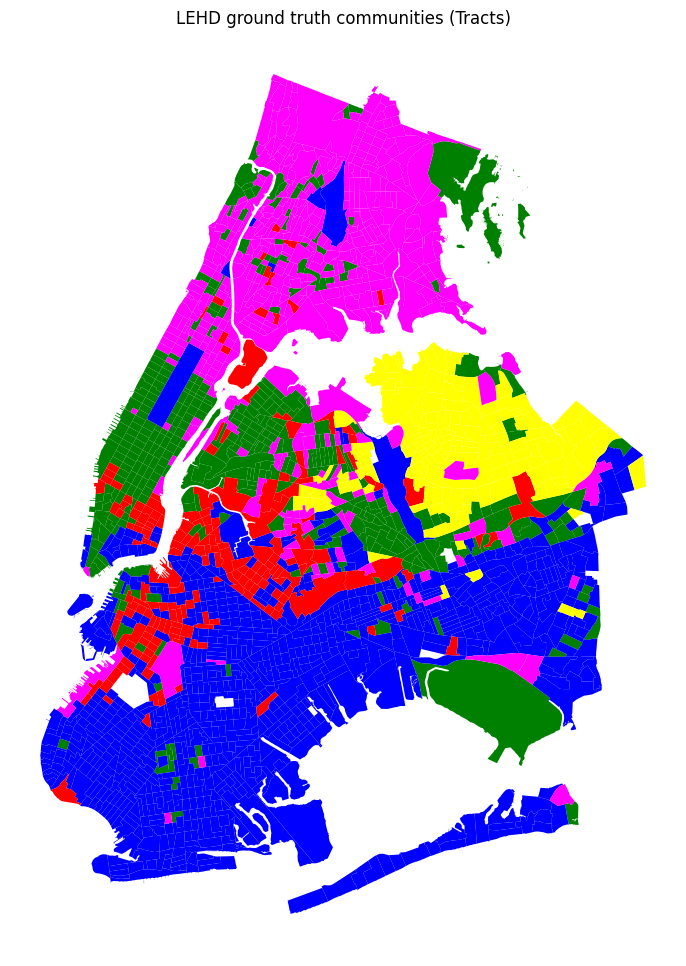

In [71]:
# visualizePartitionShape(tracts_gdf, resGt[0], 'geoid', plttitle = 'LEHD ground truth communities')
gdf = tracts_gdf
Y = resGt[0]
idfield = 'geoid'
plttitle = 'LEHD ground truth communities (Tracts)'
#visualize shapes using communities for picking colors
colors=['green','blue','red','yellow','magenta', 'orange', 'purple', 'gray', 'cyan']
f, ax = plt.subplots(1, figsize=(12, 12))
for c in range(max(Y.values())+1): #for each cluster
    if idfield=='index':
        ID=gdf.index
    else:
        ID=gdf[idfield]
    gdf.loc[(ID).map(Y)==c].plot(axes=ax, color=colors[c]) #visualize tracts which belong to it using cluster color
ax.axis('off')
plt.title(plttitle)
plt.savefig('../Outputs/LEHD_gt_pycombo_comms.png')
plt.show()


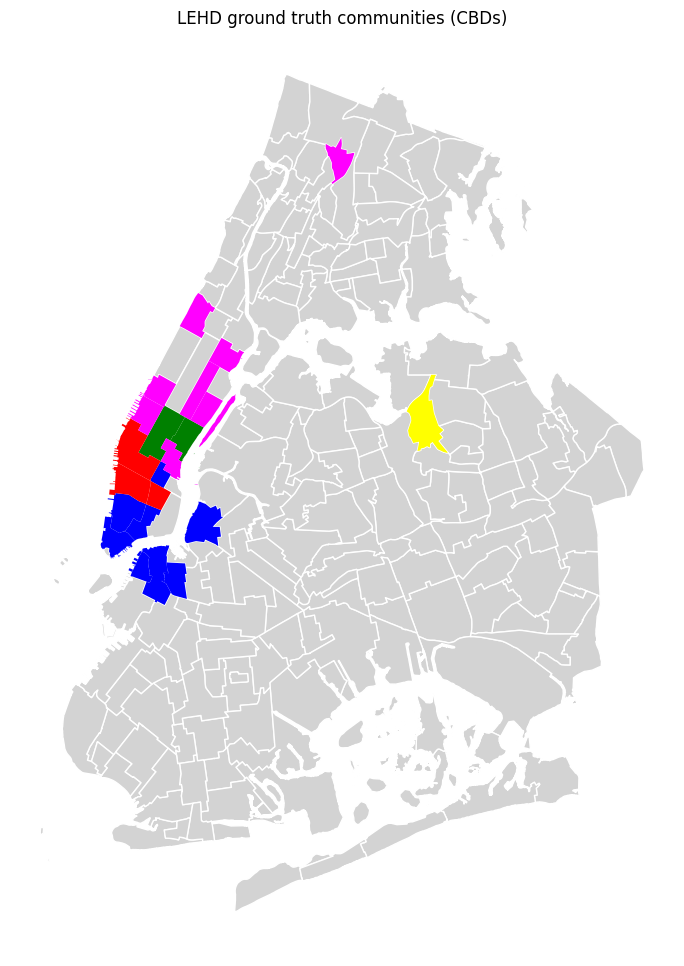

In [72]:
gdf = NTA_CBD
Y = resGt[0]
idfield = 'ntacode'
plttitle = 'LEHD ground truth communities (CBDs)'
#visualize shapes using communities for picking colors
colors=['green','blue','red','yellow','magenta', 'orange', 'purple', 'gray', 'cyan']
f, ax = plt.subplots(1, figsize=(12, 12))
nta.plot(ax = ax, color = 'lightgrey',edgecolor = 'white')

for c in range(max(Y.values())+1): #for each cluster
    if idfield=='index':
        ID=gdf.index
    else:
        ID=gdf[idfield]
    gdf.loc[(ID).map(Y)==c].plot(axes=ax, color=colors[c]) #visualize tracts which belong to it using cluster color

ax.axis('off')
plt.title(plttitle)
plt.savefig('../Outputs/LEHD_gt_pycombo_comms_ntas.png')
plt.show()

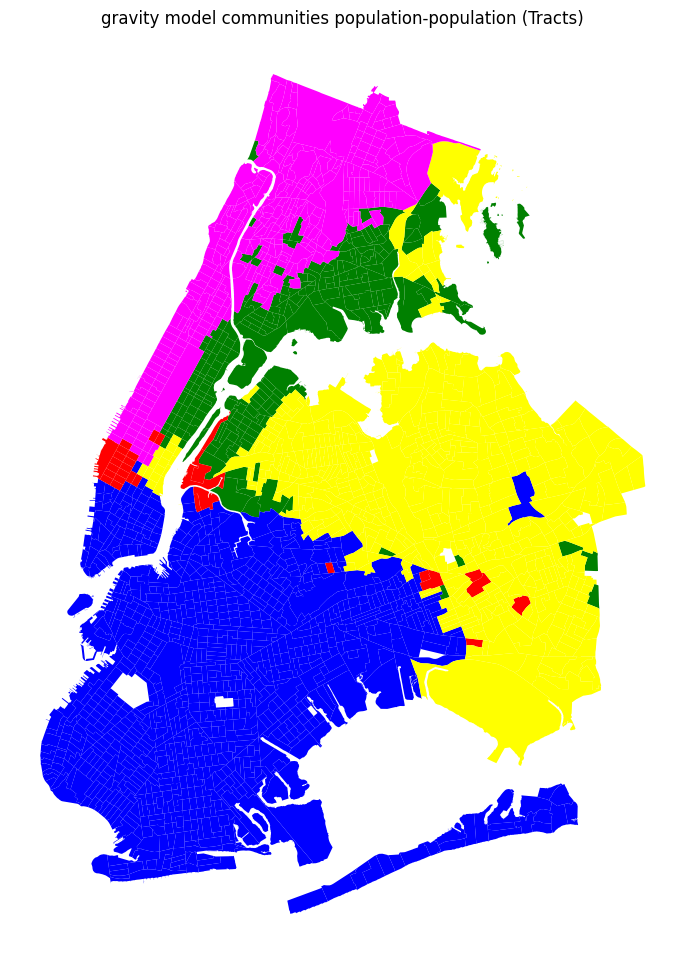

In [73]:
#population-population gravity model results

y = grav_data[['O_Tract', 'D_ntacode', 'pred_pop_pop']]
G = nx.from_pandas_edgelist(y, 'O_Tract', 'D_ntacode', 'pred_pop_pop')

resPred = pycombo.execute(G, weight='pred_pop_pop', max_communities=6)

# visualizePartitionShape(tracts_gdf, resPred[0], 'geoid', plttitle = 'gravity model communities (population-population)')
gdf = tracts_gdf
Y = resPred[0]
idfield = 'geoid'
plttitle = 'gravity model communities population-population (Tracts)'
#visualize shapes using communities for picking colors
colors=['green','blue','red','yellow','magenta', 'orange', 'purple', 'gray', 'cyan']
f, ax = plt.subplots(1, figsize=(12, 12))
for c in range(max(Y.values())+1): #for each cluster
    if idfield=='index':
        ID=gdf.index
    else:
        ID=gdf[idfield]
    gdf.loc[(ID).map(Y)==c].plot(axes=ax, color=colors[c]) #visualize tracts which belong to it using cluster color
ax.axis('off')
plt.title(plttitle)
plt.savefig('../Outputs/p2p_gravmodel_pycombo_comms.png')
plt.show()


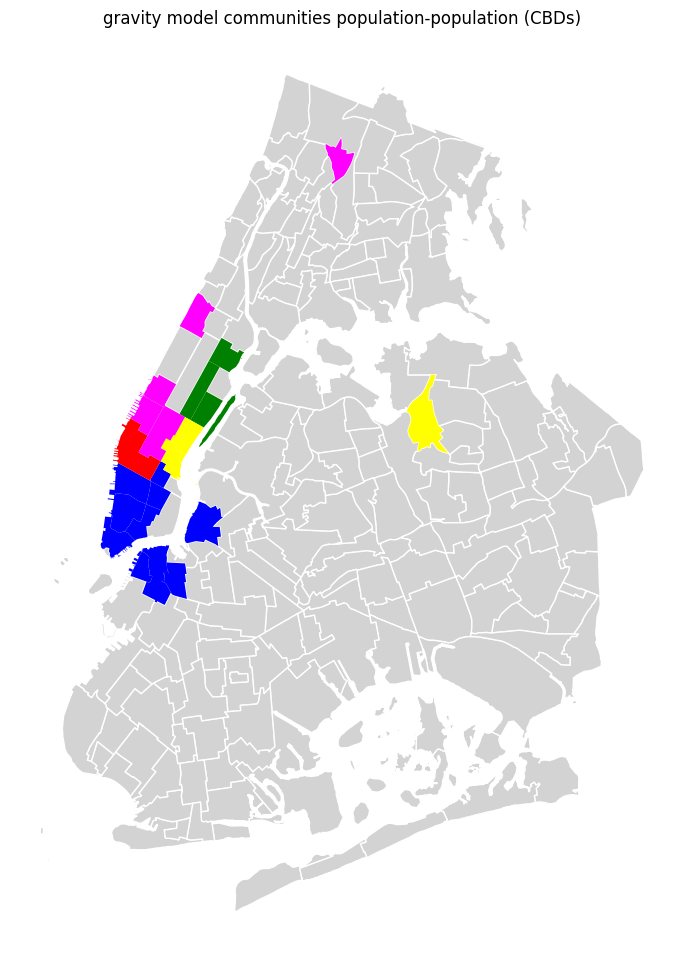

In [74]:
gdf = NTA_CBD
Y = resPred[0]
idfield = 'ntacode'
plttitle = 'gravity model communities population-population (CBDs)'
#visualize shapes using communities for picking colors
colors=['green','blue','red','yellow','magenta', 'orange', 'purple', 'gray', 'cyan']
f, ax = plt.subplots(1, figsize=(12, 12))
nta.plot(ax = ax, color = 'lightgrey',edgecolor = 'white')

for c in range(max(Y.values())+1): #for each cluster
    if idfield=='index':
        ID=gdf.index
    else:
        ID=gdf[idfield]
    gdf.loc[(ID).map(Y)==c].plot(axes=ax, color=colors[c]) #visualize tracts which belong to it using cluster color

ax.axis('off')
plt.title(plttitle)
plt.savefig('../Outputs/p2p_gravmodel_pycombo_comms_ntas.png')
plt.show()

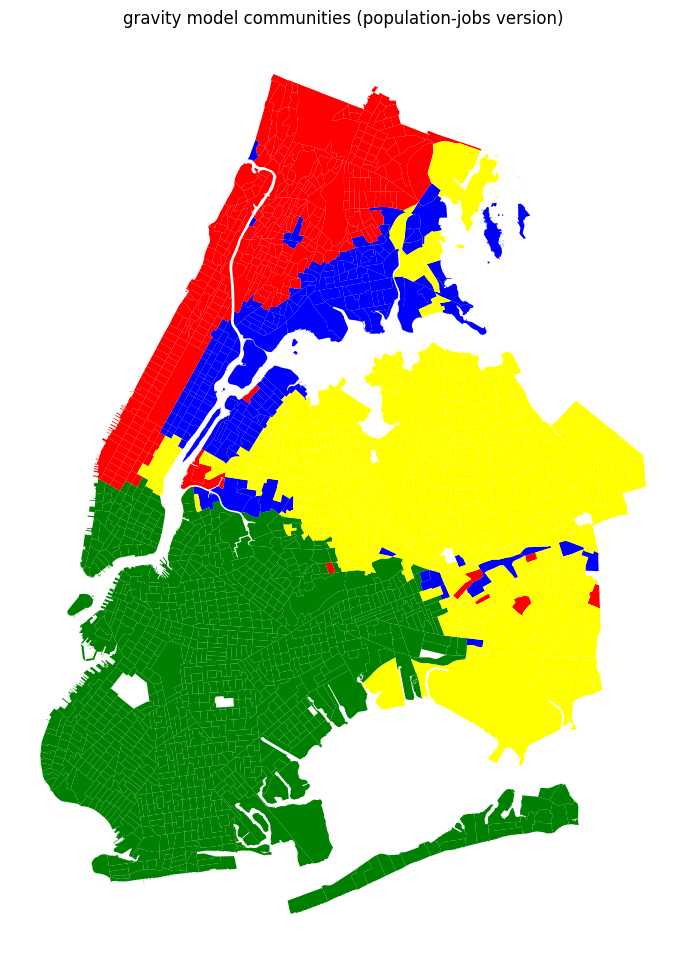

In [37]:
# gravity model results

y = grav_data[['O_Tract', 'D_ntacode', 'pred_pop_jobs']]
G = nx.from_pandas_edgelist(y, 'O_Tract', 'D_ntacode', 'pred_pop_jobs')

resPred = pycombo.execute(G, weight='pred_pop_jobs')
visualizePartitionShape(tracts_gdf, resPred[0], 'geoid', plttitle = 'gravity model communities (population-jobs version)')